# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=35,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-22-21/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5014 | MulticlassF1Score=0.1561
Batch-30 : CrossEntropyLoss=2.4751 | MulticlassF1Score=0.2010
Batch-45 : CrossEntropyLoss=2.4370 | MulticlassF1Score=0.2402
Batch-60 : CrossEntropyLoss=2.4311 | MulticlassF1Score=0.2717
Batch-75 : CrossEntropyLoss=2.4452 | MulticlassF1Score=0.2922
Batch-90 : CrossEntropyLoss=2.4064 | MulticlassF1Score=0.3145
Batch-105: CrossEntropyLoss=2.3940 | MulticlassF1Score=0.3372
Batch-120: CrossEntropyLoss=2.4084 | MulticlassF1Score=0.3575
Batch-135: CrossEntropyLoss=2.3819 | MulticlassF1Score=0.3799
Batch-150: CrossEntropyLoss=2.3694 | MulticlassF1Score=0.4002
Batch-165: CrossEntropyLoss=2.3642 | MulticlassF1Score=0.4170
Batch-180: CrossEntropyLoss=2.3594 | MulticlassF1Score=0.4305
Batch-195: CrossEntropyLoss=2.3625 | MulticlassF1Score=0.4425
Batch-210: CrossEntropyLoss=2.3683 | MulticlassF1Score=0.4539
Batch-225: CrossEntropyLoss=2.3633 | MulticlassF1Score=0.4635
Batch-226: CrossEntropyLoss=2.3729 | MulticlassF1Score=0.4639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3823 | MulticlassF1Score=0.5893
Batch-30 : CrossEntropyLoss=2.3935 | MulticlassF1Score=0.5887
Batch-45 : CrossEntropyLoss=2.3742 | MulticlassF1Score=0.5912
Batch-60 : CrossEntropyLoss=2.3782 | MulticlassF1Score=0.5933
Batch-63 : CrossEntropyLoss=2.3665 | MulticlassF1Score=0.5933

Training   : Mean CrossEntropyLoss = 2.4243 | Mean MulticlassF1Score = 0.3319
Validation : Mean CrossEntropyLoss = 2.3737 | Mean MulticlassF1Score = 0.5905

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3617 | MulticlassF1Score=0.6230
Batch-30 : CrossEntropyLoss=2.3511 | MulticlassF1Score=0.6364
Batch-45 : CrossEntropyLoss=2.3339 | MulticlassF1Score=0.6609
Batch-60 : CrossEntropyLoss=2.3338 | MulticlassF1Score=0.6735
Batch-75 : CrossEntropyLoss=2.3424 | MulticlassF1Score=0.6812
Batch-90 : CrossEntropyLoss=2.3293 | MulticlassF1Score=0.6879
Batch-105: CrossEntropyLoss=2.3412 | MulticlassF1Score=0.6918
Batch-120: CrossEntropyLoss=2.3276 | MulticlassF1Score=0.6948
Batch-135: CrossEntropyLoss=2.3220 | MulticlassF1Score=0.6977
Batch-150: CrossEntropyLoss=2.3283 | MulticlassF1Score=0.6998
Batch-165: CrossEntropyLoss=2.3431 | MulticlassF1Score=0.7018
Batch-180: CrossEntropyLoss=2.3302 | MulticlassF1Score=0.7066
Batch-195: CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7122
Batch-210: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7170
Batch-225: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7218
Batch-226: CrossEntropyLoss=2.3223 | MulticlassF1Score=0.7220

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7903
Batch-30 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7901
Batch-45 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7902
Batch-60 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7883
Batch-63 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7883

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3352 | Mean MulticlassF1Score = 0.6835
Validation : Mean CrossEntropyLoss = 2.3145 | Mean MulticlassF1Score = 0.7916

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.7907
Batch-30 : CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7911
Batch-45 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7889
Batch-60 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7882
Batch-75 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7892
Batch-90 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7893
Batch-105: CrossEntropyLoss=2.3118 | MulticlassF1Score=0.7884
Batch-120: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7896
Batch-135: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7894
Batch-150: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7905
Batch-165: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.7912
Batch-180: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.7914
Batch-195: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.7917
Batch-210: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7923
Batch-225: CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7927
Batch-226: CrossEntropyLoss=2.3290 | MulticlassF1Score=0.7925

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7878
Batch-30 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.7903
Batch-45 : CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7926
Batch-60 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7927
Batch-63 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7930

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3123 | Mean MulticlassF1Score = 0.7907
Validation : Mean CrossEntropyLoss = 2.3125 | Mean MulticlassF1Score = 0.7900

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7943
Batch-30 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.7944
Batch-45 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7933
Batch-60 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7946
Batch-75 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.7953
Batch-90 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.7955
Batch-105: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7980
Batch-120: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8005
Batch-135: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.8022
Batch-150: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8042
Batch-165: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8055
Batch-180: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8072
Batch-195: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8093
Batch-210: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8106
Batch-225: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8117
Batch-226: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8118

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8266
Batch-30 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8245
Batch-45 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8250
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8251
Batch-63 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8255

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3062 | Mean MulticlassF1Score = 0.8002
Validation : Mean CrossEntropyLoss = 2.3023 | Mean MulticlassF1Score = 0.8262

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8264
Batch-30 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8302
Batch-45 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8304
Batch-60 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8317
Batch-75 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8297
Batch-90 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8310
Batch-105: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8307
Batch-120: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8301
Batch-135: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8301
Batch-150: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8303
Batch-165: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8306
Batch-180: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8303
Batch-195: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8305
Batch-210: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8304
Batch-225: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8303
Batch-226: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8303

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8301
Batch-30 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8290
Batch-45 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8272
Batch-60 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8277
Batch-63 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8279

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8302
Validation : Mean CrossEntropyLoss = 2.3014 | Mean MulticlassF1Score = 0.8268

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8332
Batch-30 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8326
Batch-45 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8325
Batch-60 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8303
Batch-75 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8308
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8315
Batch-105: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8332
Batch-120: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8329
Batch-135: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8333
Batch-150: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8332
Batch-165: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8331
Batch-180: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8329
Batch-195: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8324
Batch-210: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8328
Batch-225: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8325
Batch-226: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8326

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8265
Batch-30 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8262
Batch-45 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8263
Batch-60 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8293
Batch-63 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8288

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8326
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8252

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8374
Batch-30 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8366
Batch-45 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8361
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8362
Batch-75 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8350
Batch-90 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8353
Batch-105: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8361
Batch-120: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8356
Batch-135: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8350
Batch-150: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8346
Batch-165: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8352
Batch-180: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8352
Batch-195: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8353
Batch-210: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8350
Batch-225: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8352
Batch-226: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8352

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8296
Batch-30 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8277
Batch-45 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8299
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8308
Batch-63 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8311

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8356
Validation : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8295

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8364
Batch-30 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8447
Batch-45 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8466
Batch-60 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8488
Batch-75 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8491
Batch-90 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8488
Batch-105: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8493
Batch-120: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8490
Batch-135: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8481
Batch-150: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8480
Batch-165: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8485
Batch-180: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8493
Batch-195: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8495
Batch-210: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8499
Batch-225: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8504
Batch-226: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8504

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8508
Batch-30 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8503
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8492
Batch-60 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8475
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8478

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2942 | Mean MulticlassF1Score = 0.8470
Validation : Mean CrossEntropyLoss = 2.2954 | Mean MulticlassF1Score = 0.8485

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8531
Batch-30 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8551
Batch-45 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8561
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8552
Batch-75 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8556
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8553
Batch-105: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8540
Batch-120: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8538
Batch-135: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8529
Batch-150: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8533
Batch-165: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8534
Batch-180: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8532
Batch-195: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8539
Batch-210: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8555
Batch-225: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8568
Batch-226: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8569

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8745
Batch-30 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8708
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8726
Batch-60 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8710
Batch-63 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8712

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2920 | Mean MulticlassF1Score = 0.8543
Validation : Mean CrossEntropyLoss = 2.2881 | Mean MulticlassF1Score = 0.8724

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8774
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8800
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8800
Batch-60 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8801
Batch-75 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8800
Batch-90 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8798
Batch-105: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8796
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8797
Batch-135: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8798
Batch-150: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8799
Batch-165: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8798
Batch-180: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8801
Batch-195: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8806
Batch-210: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8807
Batch-225: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8811
Batch-226: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8811

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8794
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8793
Batch-45 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8779
Batch-60 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8774
Batch-63 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8769

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2847 | Mean MulticlassF1Score = 0.8799
Validation : Mean CrossEntropyLoss = 2.2862 | Mean MulticlassF1Score = 0.8787

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8916
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8882
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8872
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8854
Batch-75 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8846
Batch-90 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8842
Batch-105: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8841
Batch-120: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8848
Batch-135: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8844
Batch-150: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8849
Batch-165: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8857
Batch-180: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8852
Batch-195: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8844
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8848
Batch-225: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8858
Batch-226: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8859

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8986
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9001
Batch-45 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8991
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8989
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8989

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8857
Validation : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8989

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9087
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9072
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9071
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9059
Batch-75 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9062
Batch-90 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9064
Batch-105: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9067
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9068
Batch-135: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9066
Batch-150: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9070
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9074
Batch-180: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9074
Batch-195: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9078
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9078
Batch-225: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9077
Batch-226: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9077

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8977
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9017
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.9001
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9001
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9009

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9070
Validation : Mean CrossEntropyLoss = 2.2787 | Mean MulticlassF1Score = 0.9008

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9091
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9124
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9128
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9131
Batch-75 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9132
Batch-90 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9129
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9131
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9139
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9139
Batch-150: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9138
Batch-165: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9144
Batch-180: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9143
Batch-195: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9144
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9141
Batch-225: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9140
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9141

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9060
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9092
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9078
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9066
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9069

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9129
Validation : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9079

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9162
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9168
Batch-75 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9165
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9170
Batch-105: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9169
Batch-120: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9165
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9169
Batch-150: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9171
Batch-165: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9170
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9173
Batch-195: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9176
Batch-210: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9177
Batch-225: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9174
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9173

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9102
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9089
Batch-45 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9078
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9088
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9088

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9166
Validation : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9070

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9197
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9196
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9194
Batch-90 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9183
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9186
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9189
Batch-135: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9192
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9187
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9188
Batch-180: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9190
Batch-195: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9184
Batch-210: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9184
Batch-225: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9183
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9183

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9068
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9088
Batch-45 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9067
Batch-60 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9073
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9079

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9192
Validation : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9070

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9167
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9163
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9166
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9189
Batch-90 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9194
Batch-105: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9193
Batch-120: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9188
Batch-135: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9193
Batch-150: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9196
Batch-165: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9197
Batch-180: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9193
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9194
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9193
Batch-225: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9194
Batch-226: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9193

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9080
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9080
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9093
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9090
Batch-63 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9083

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9185
Validation : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9076

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9196
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9208
Batch-75 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9201
Batch-90 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9199
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9197
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9195
Batch-135: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9196
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9194
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9197
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9197
Batch-195: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9197
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9200
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9199
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9199

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9104
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9087
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9077
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9087
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9086

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9199
Validation : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9081

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9197
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9216
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9215
Batch-90 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9220
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9220
Batch-120: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9218
Batch-135: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9218
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9216
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9216
Batch-180: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9211
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9211
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9210
Batch-225: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9209
Batch-226: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9208

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9083
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9095
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9085
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9087
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9088

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9210
Validation : Mean CrossEntropyLoss = 2.2760 | Mean MulticlassF1Score = 0.9091

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9184
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9194
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9205
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9200
Batch-90 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9204
Batch-105: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9206
Batch-120: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9206
Batch-135: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9209
Batch-150: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9210
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9212
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9217
Batch-195: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9213
Batch-210: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9215
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9214
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9214

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9090
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9088
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9084
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9083
Batch-63 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9087

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9209
Validation : Mean CrossEntropyLoss = 2.2760 | Mean MulticlassF1Score = 0.9086

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9193
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9206
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9213
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9209
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9213
Batch-105: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9217
Batch-120: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9216
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9219
Batch-150: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9218
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9220
Batch-180: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9219
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9220
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9222
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9219
Batch-226: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9219

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9115
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9091
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9085
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9087

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9214
Validation : Mean CrossEntropyLoss = 2.2760 | Mean MulticlassF1Score = 0.9108

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9227
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9230
Batch-90 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9224
Batch-105: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9218
Batch-120: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9221
Batch-135: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9223
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9222
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9221
Batch-180: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9220
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9222
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9221
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9222
Batch-226: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9221

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9040
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9057
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9080
Batch-63 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9085

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9225
Validation : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9050

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9309
Batch-30 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9241
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9237
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9239
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9246
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9252
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9254
Batch-150: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9247
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9241
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9238
Batch-195: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9235
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9230
Batch-225: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9228
Batch-226: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9228

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9145
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9112
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9130
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9135
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9134

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9251
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9128
Patience = 1/50‚ùó

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9232
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9235
Batch-75 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9243
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9251
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9254
Batch-120: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9249
Batch-135: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9246
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9246
Batch-165: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9248
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9250
Batch-195: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9250
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9253
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9255
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9255

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9182
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9187
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9182
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9181

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9243
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9190

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9311
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9299
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9297
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9304
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9315
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9314
Batch-120: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9316
Batch-135: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9316
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9319
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9323
Batch-180: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9326
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9325
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9323
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9323
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9324

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9191
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9197
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9202

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9314
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9205

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9333
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9348
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9338
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9348
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9341
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9338
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9336
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9341
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9342
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9345
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9347
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9346
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9346
Batch-210: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9348
Batch-225: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9349
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9349

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9208
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9208

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9342
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9202

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9360
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9365
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9368
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9365
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9364
Batch-90 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9368
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9373
Batch-120: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9367
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9364
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9363
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9365
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9361
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9363
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9363

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9155
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9182
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9216
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9218

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9366
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9193

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9358
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9362
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9367
Batch-75 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9372
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9373
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9381
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9382
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9380
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9382
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9382

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9224

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9374
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9212

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9409
Batch-75 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9407
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9405
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9406
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9402
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9406
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9407
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9407
Batch-225: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9218
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9237

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9227

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9410
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9421
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9422
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9422
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9425
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9422
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9422
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9258

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9429
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9248

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9419
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9424
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9431
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9436
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9436

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9268
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9258

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9274

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9433
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9440
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9438
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9440
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9269
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9265

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9273

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9450
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9259

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9245

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9456
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9458
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9453
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9451
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9451
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9451
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9263

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9456
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9243

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9459
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9458
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9453
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9262

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9240

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9460
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9459
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9483
Batch-226: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9484

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9453

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9464

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9627
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9637
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9644
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9647
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9647
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9646
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9645
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9645
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9647
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9650
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9649
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9457

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9646
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9459

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9640
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9649
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9656
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9657
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9654
Batch-195: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9652
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9651
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9450

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9428

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9651
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9650
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9650
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9648
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9649
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9648
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9454
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9454

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9648
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9469

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9652
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9653
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9653
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9653
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9463

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9655
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9464

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9654
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9653
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9659
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9660
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9660
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9460

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9475

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9463

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9465

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9663
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9662
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9465

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9441

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9659
Batch-30 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9667
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9663
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9463

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9475

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9663
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9665
Batch-150: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9668
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9454
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9459

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9469

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9662
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9466

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9459

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9662
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9661
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9664
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9663
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9466

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9484
Patience = 2/50‚ùó

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9672
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9647
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9649
Batch-180: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9647
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9644
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9644
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9641
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9454

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9659
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9463
Patience = 3/50‚ùó

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9647
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9647
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9640
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9641
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9639
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9636
Batch-120: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9636
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9637
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9640
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9643
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9646
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9644
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9646

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9463

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9642
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9456

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9652
Batch-30 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9672
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9661
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9660
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9463

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9460

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9432
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9465

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9449

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2576
Best CrossEntropyLoss training    : 2.2642
Best MulticlassF1Score validation : 0.9673
Best MulticlassF1Score validation : 0.9449
Training duration                 : 2.3230 minutes.
Training date                     : 2022-10-19 09:59:03.166832+08:00


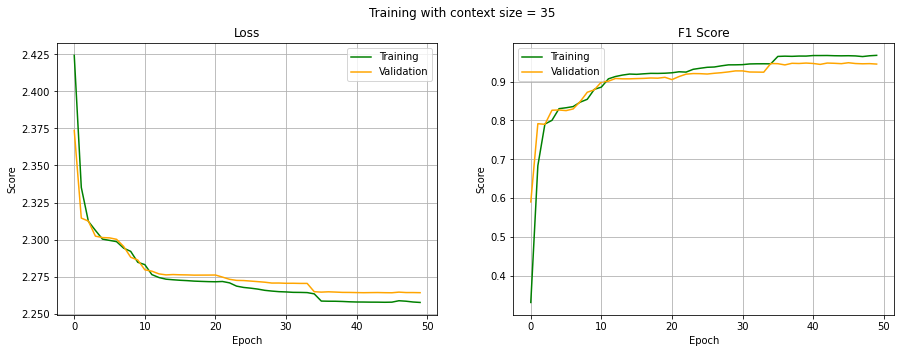

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9674, device='cuda:0'),
 tensor(0.9465, device='cuda:0'),
 tensor(0.9452, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9674, device='cuda:0'),
 tensor(0.9465, device='cuda:0'),
 tensor(0.9452, device='cuda:0'))

## Heatmap

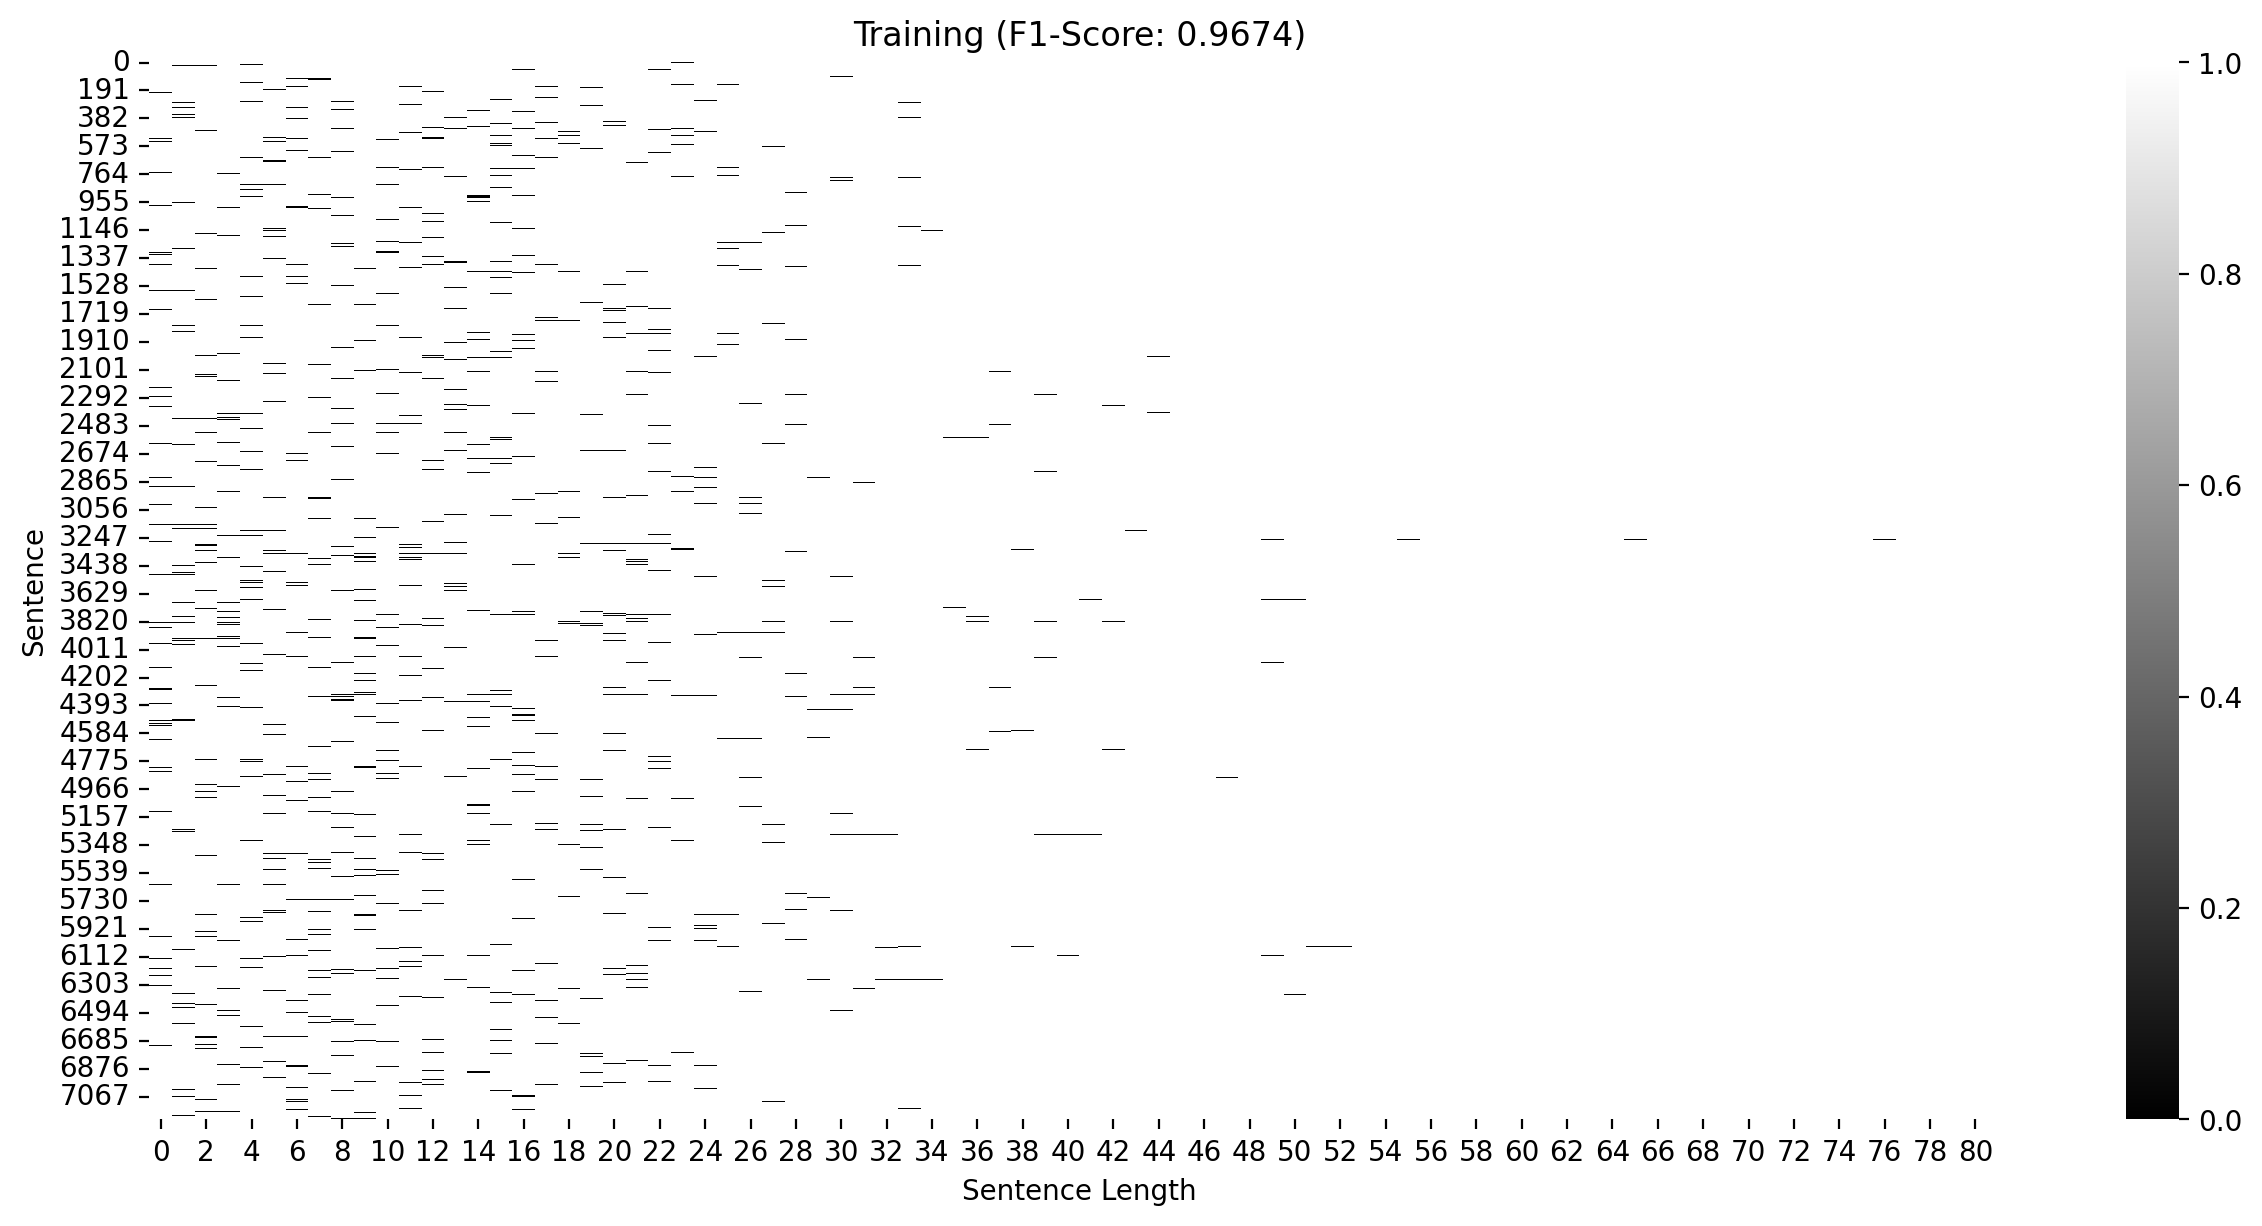

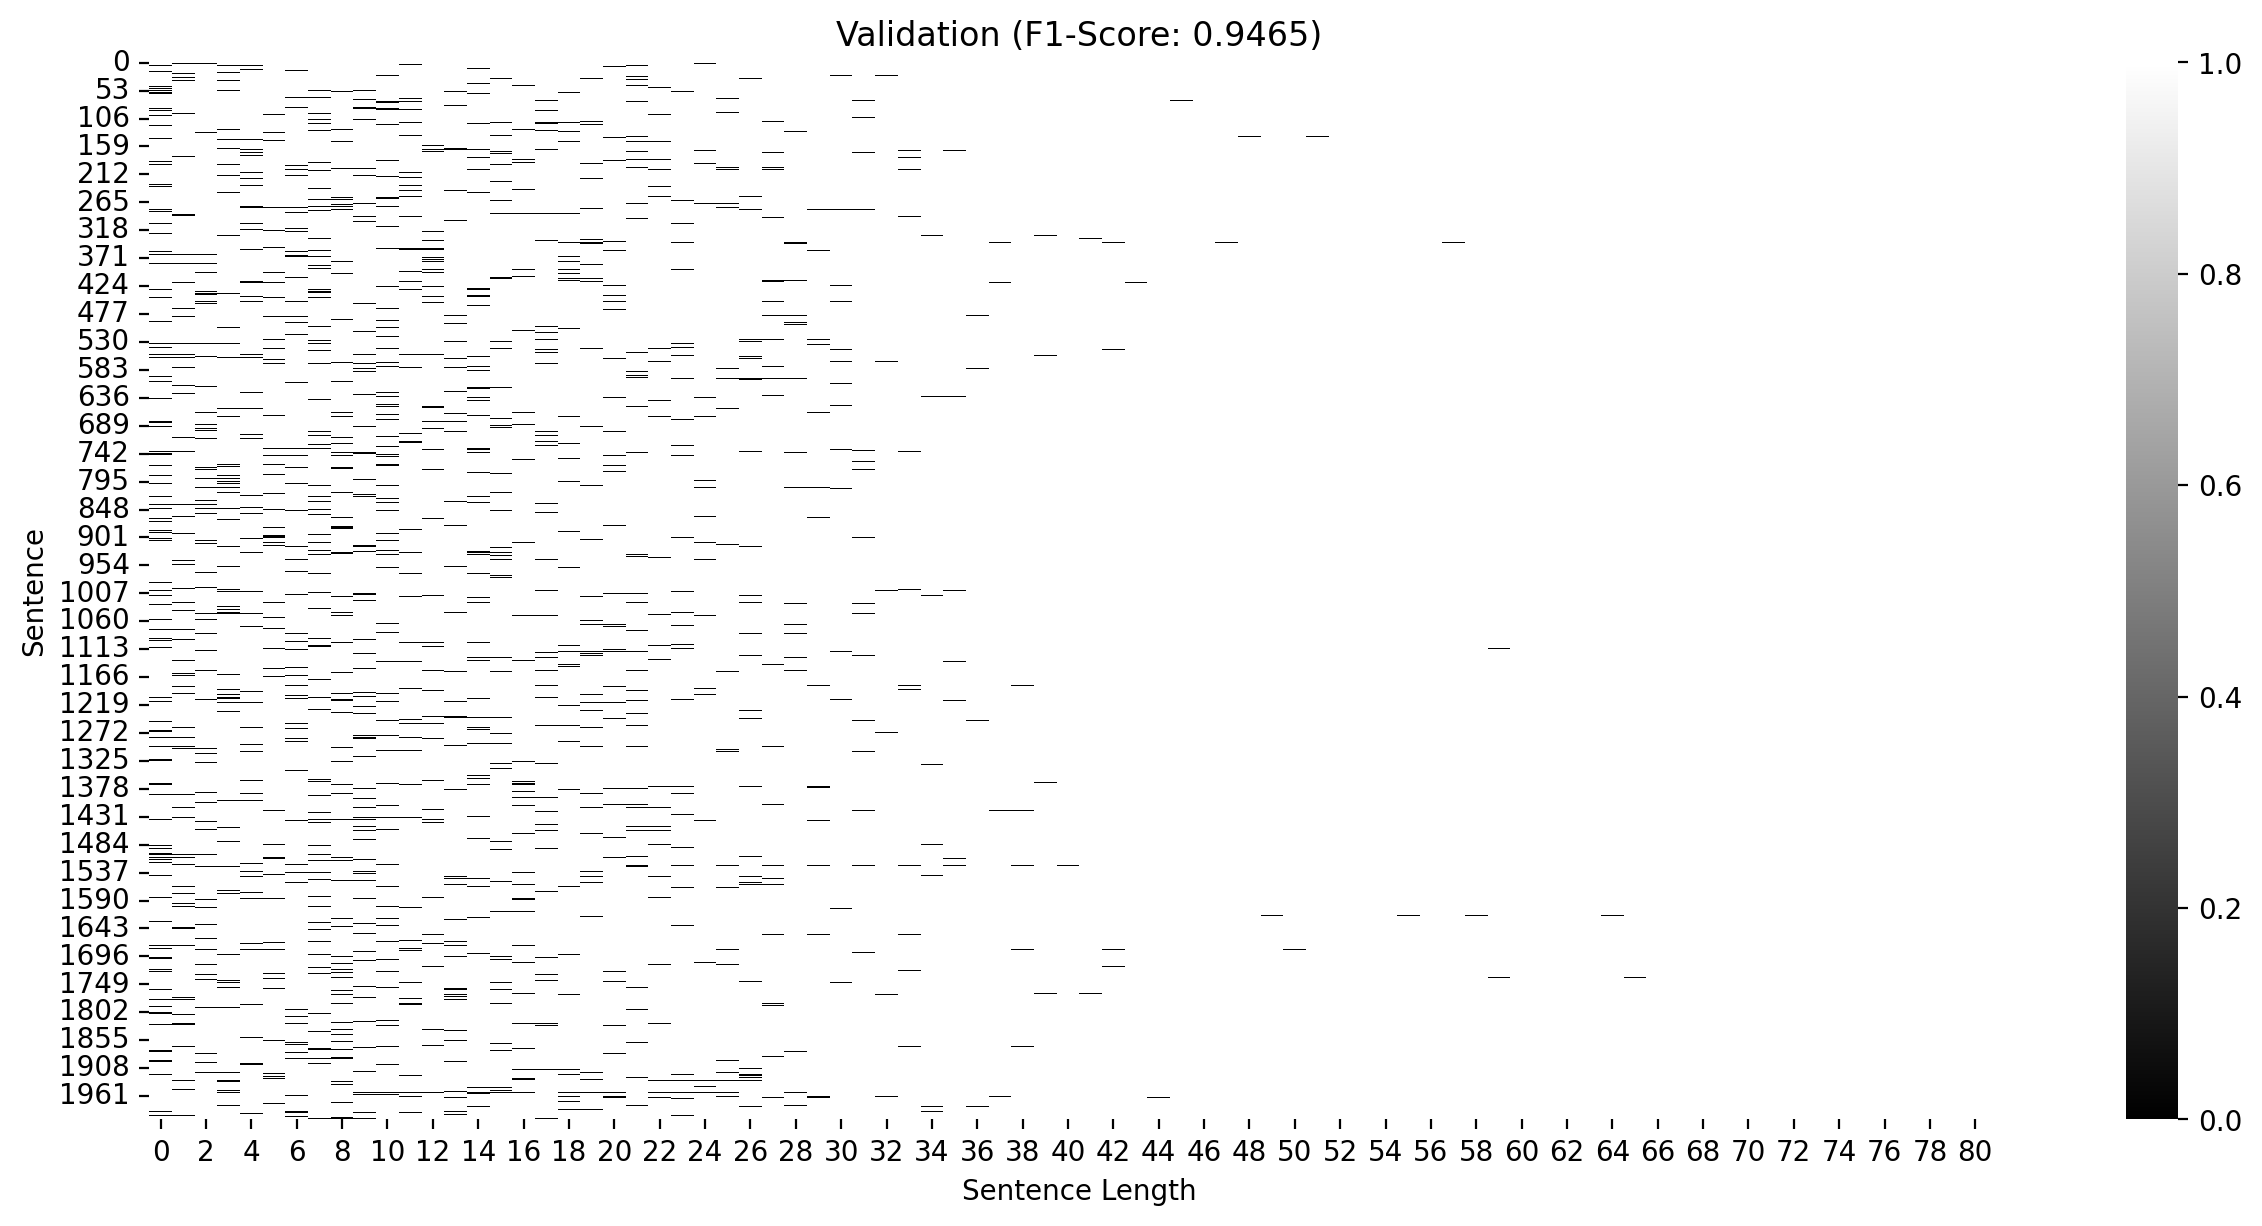

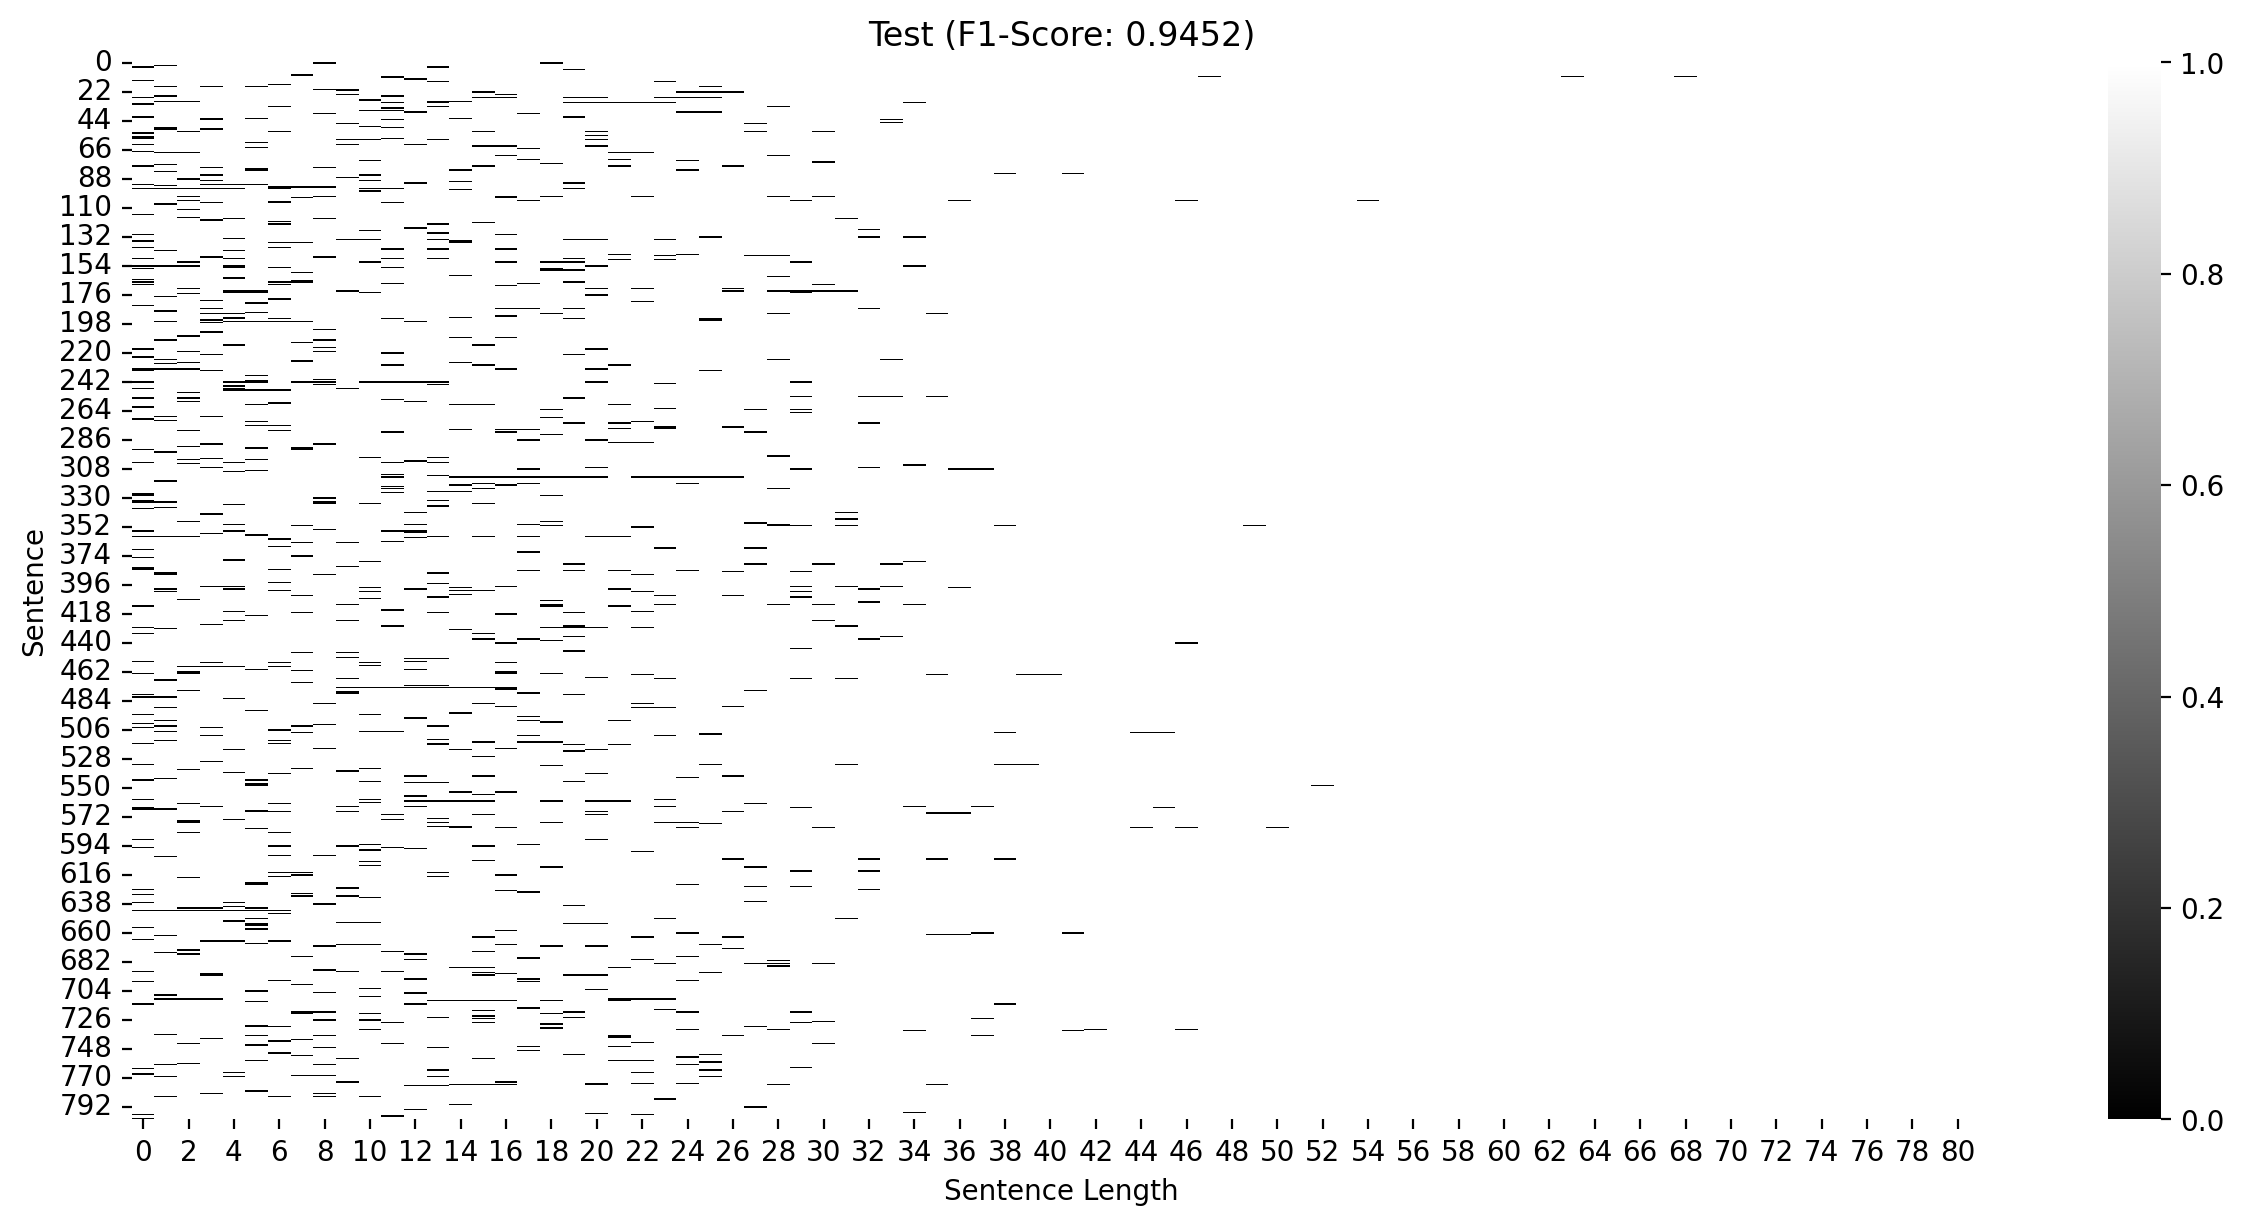

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


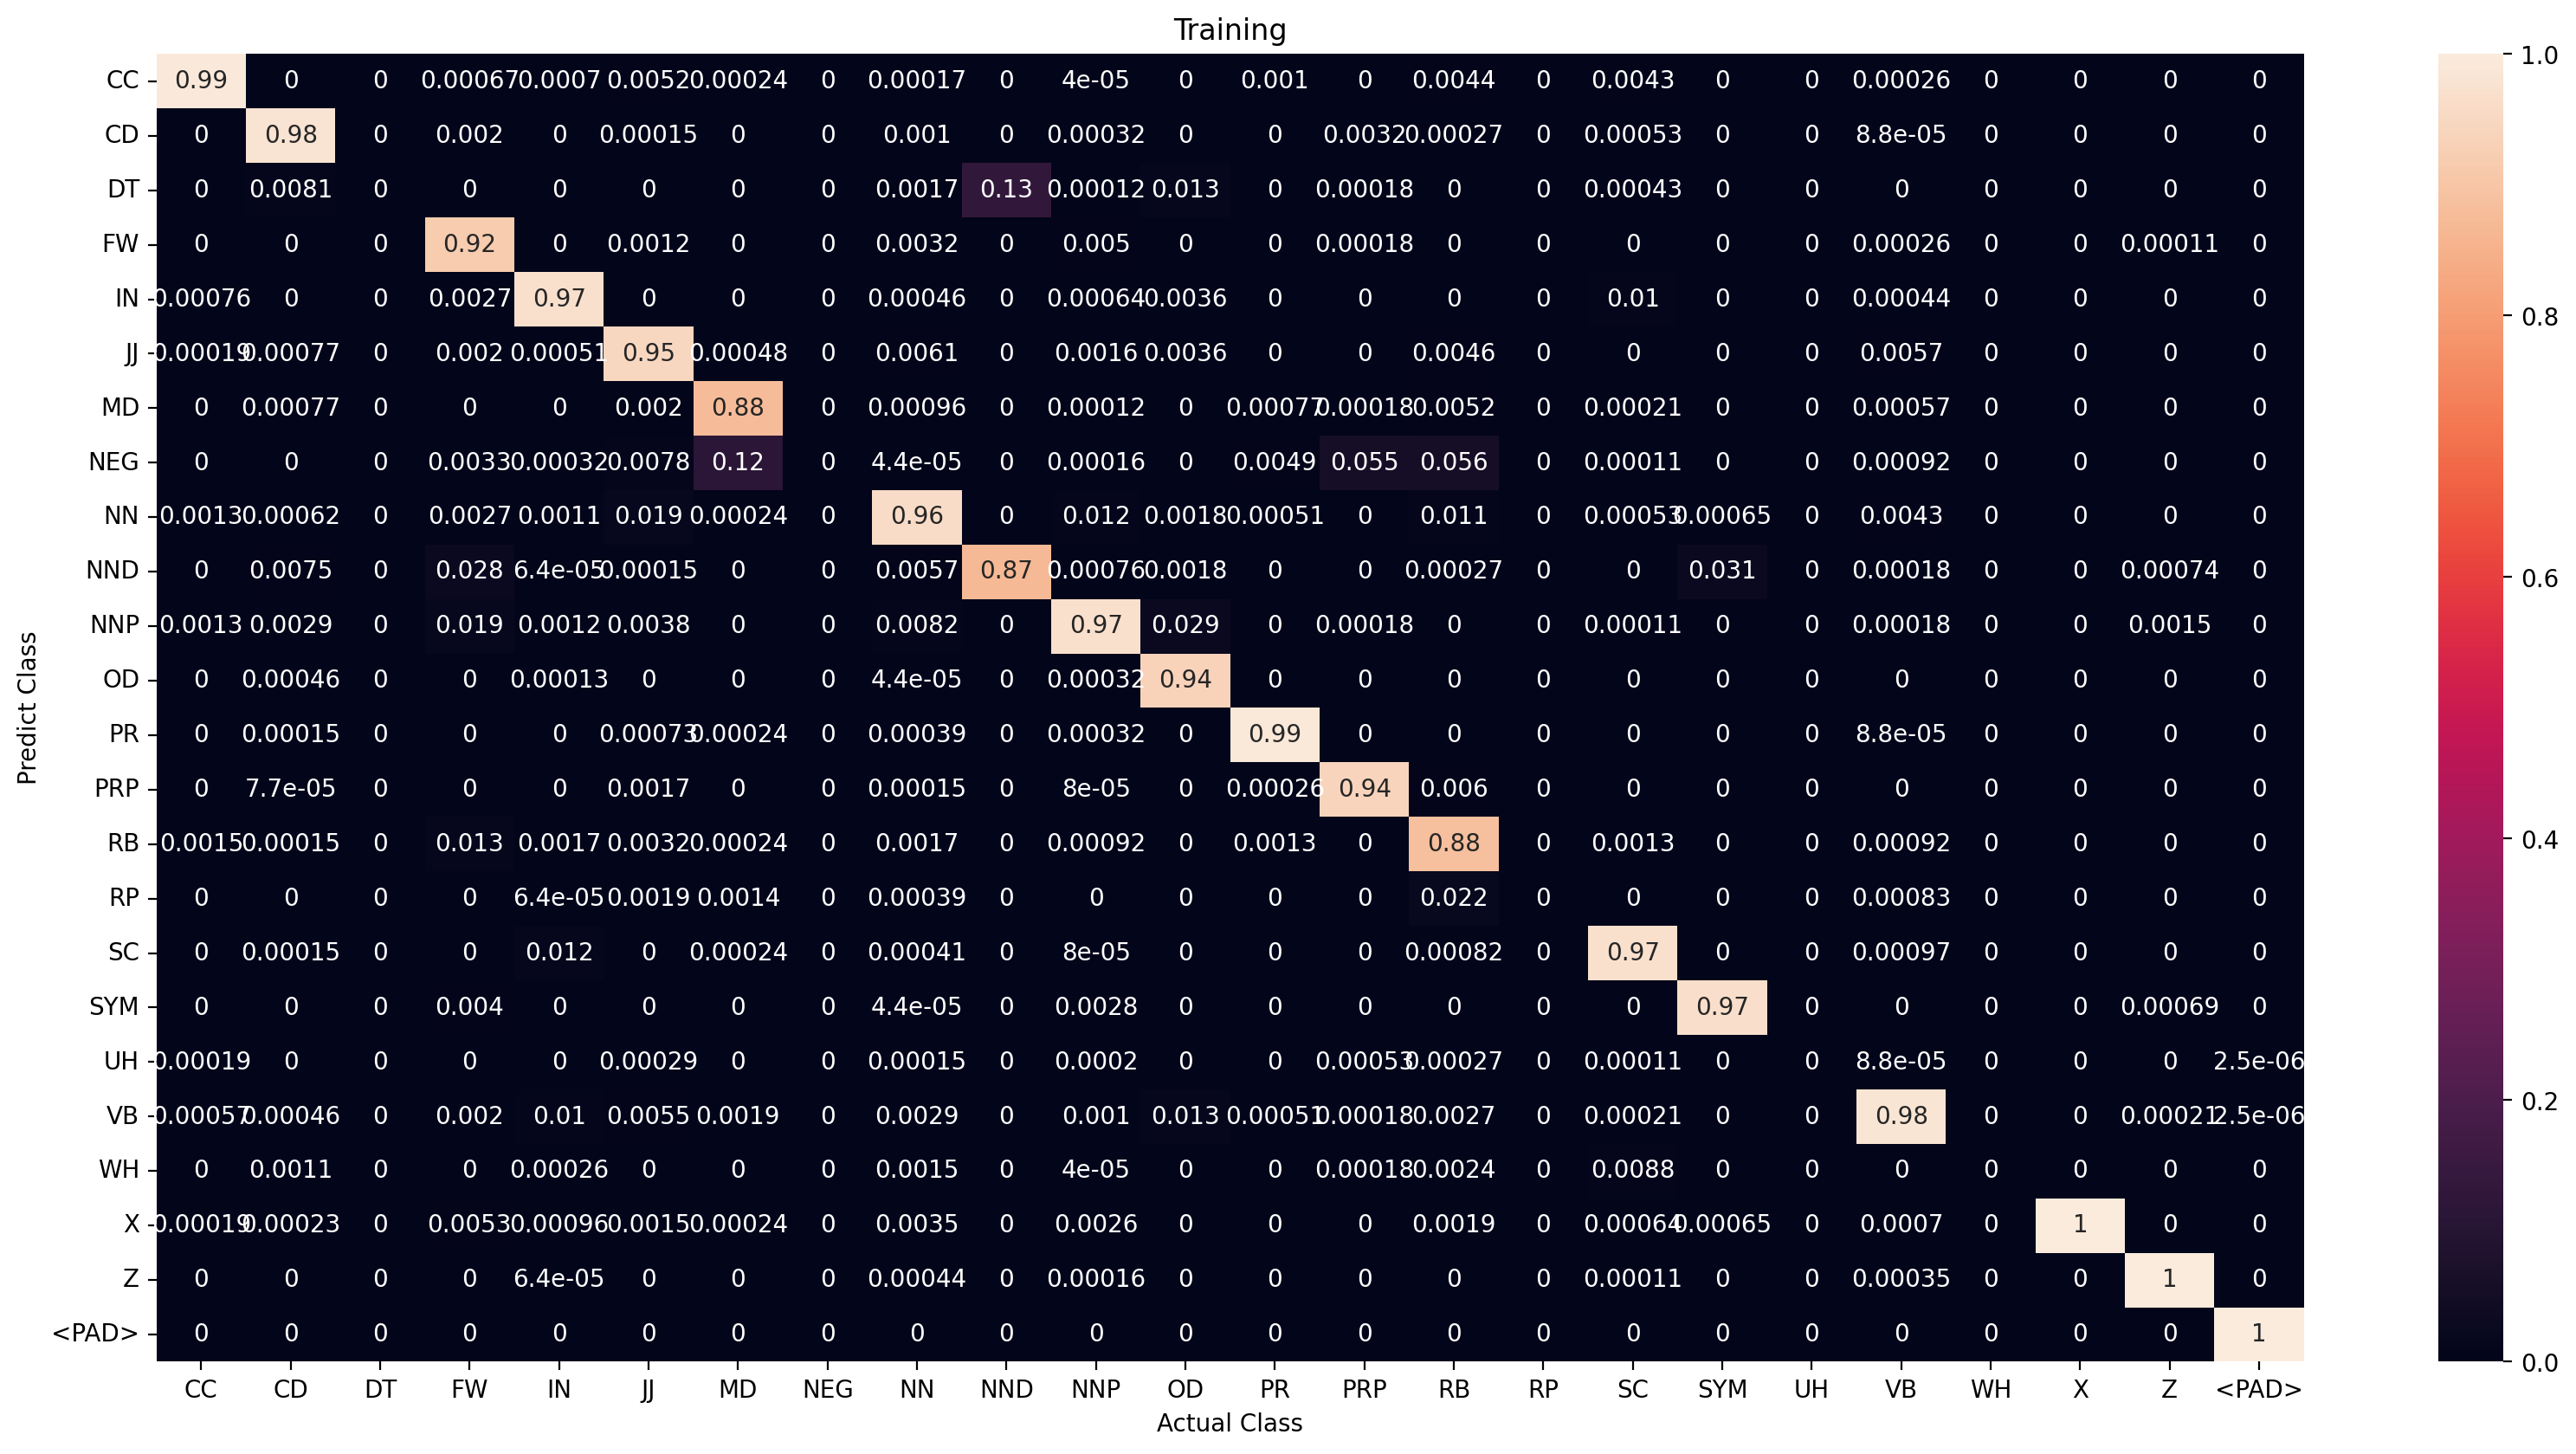

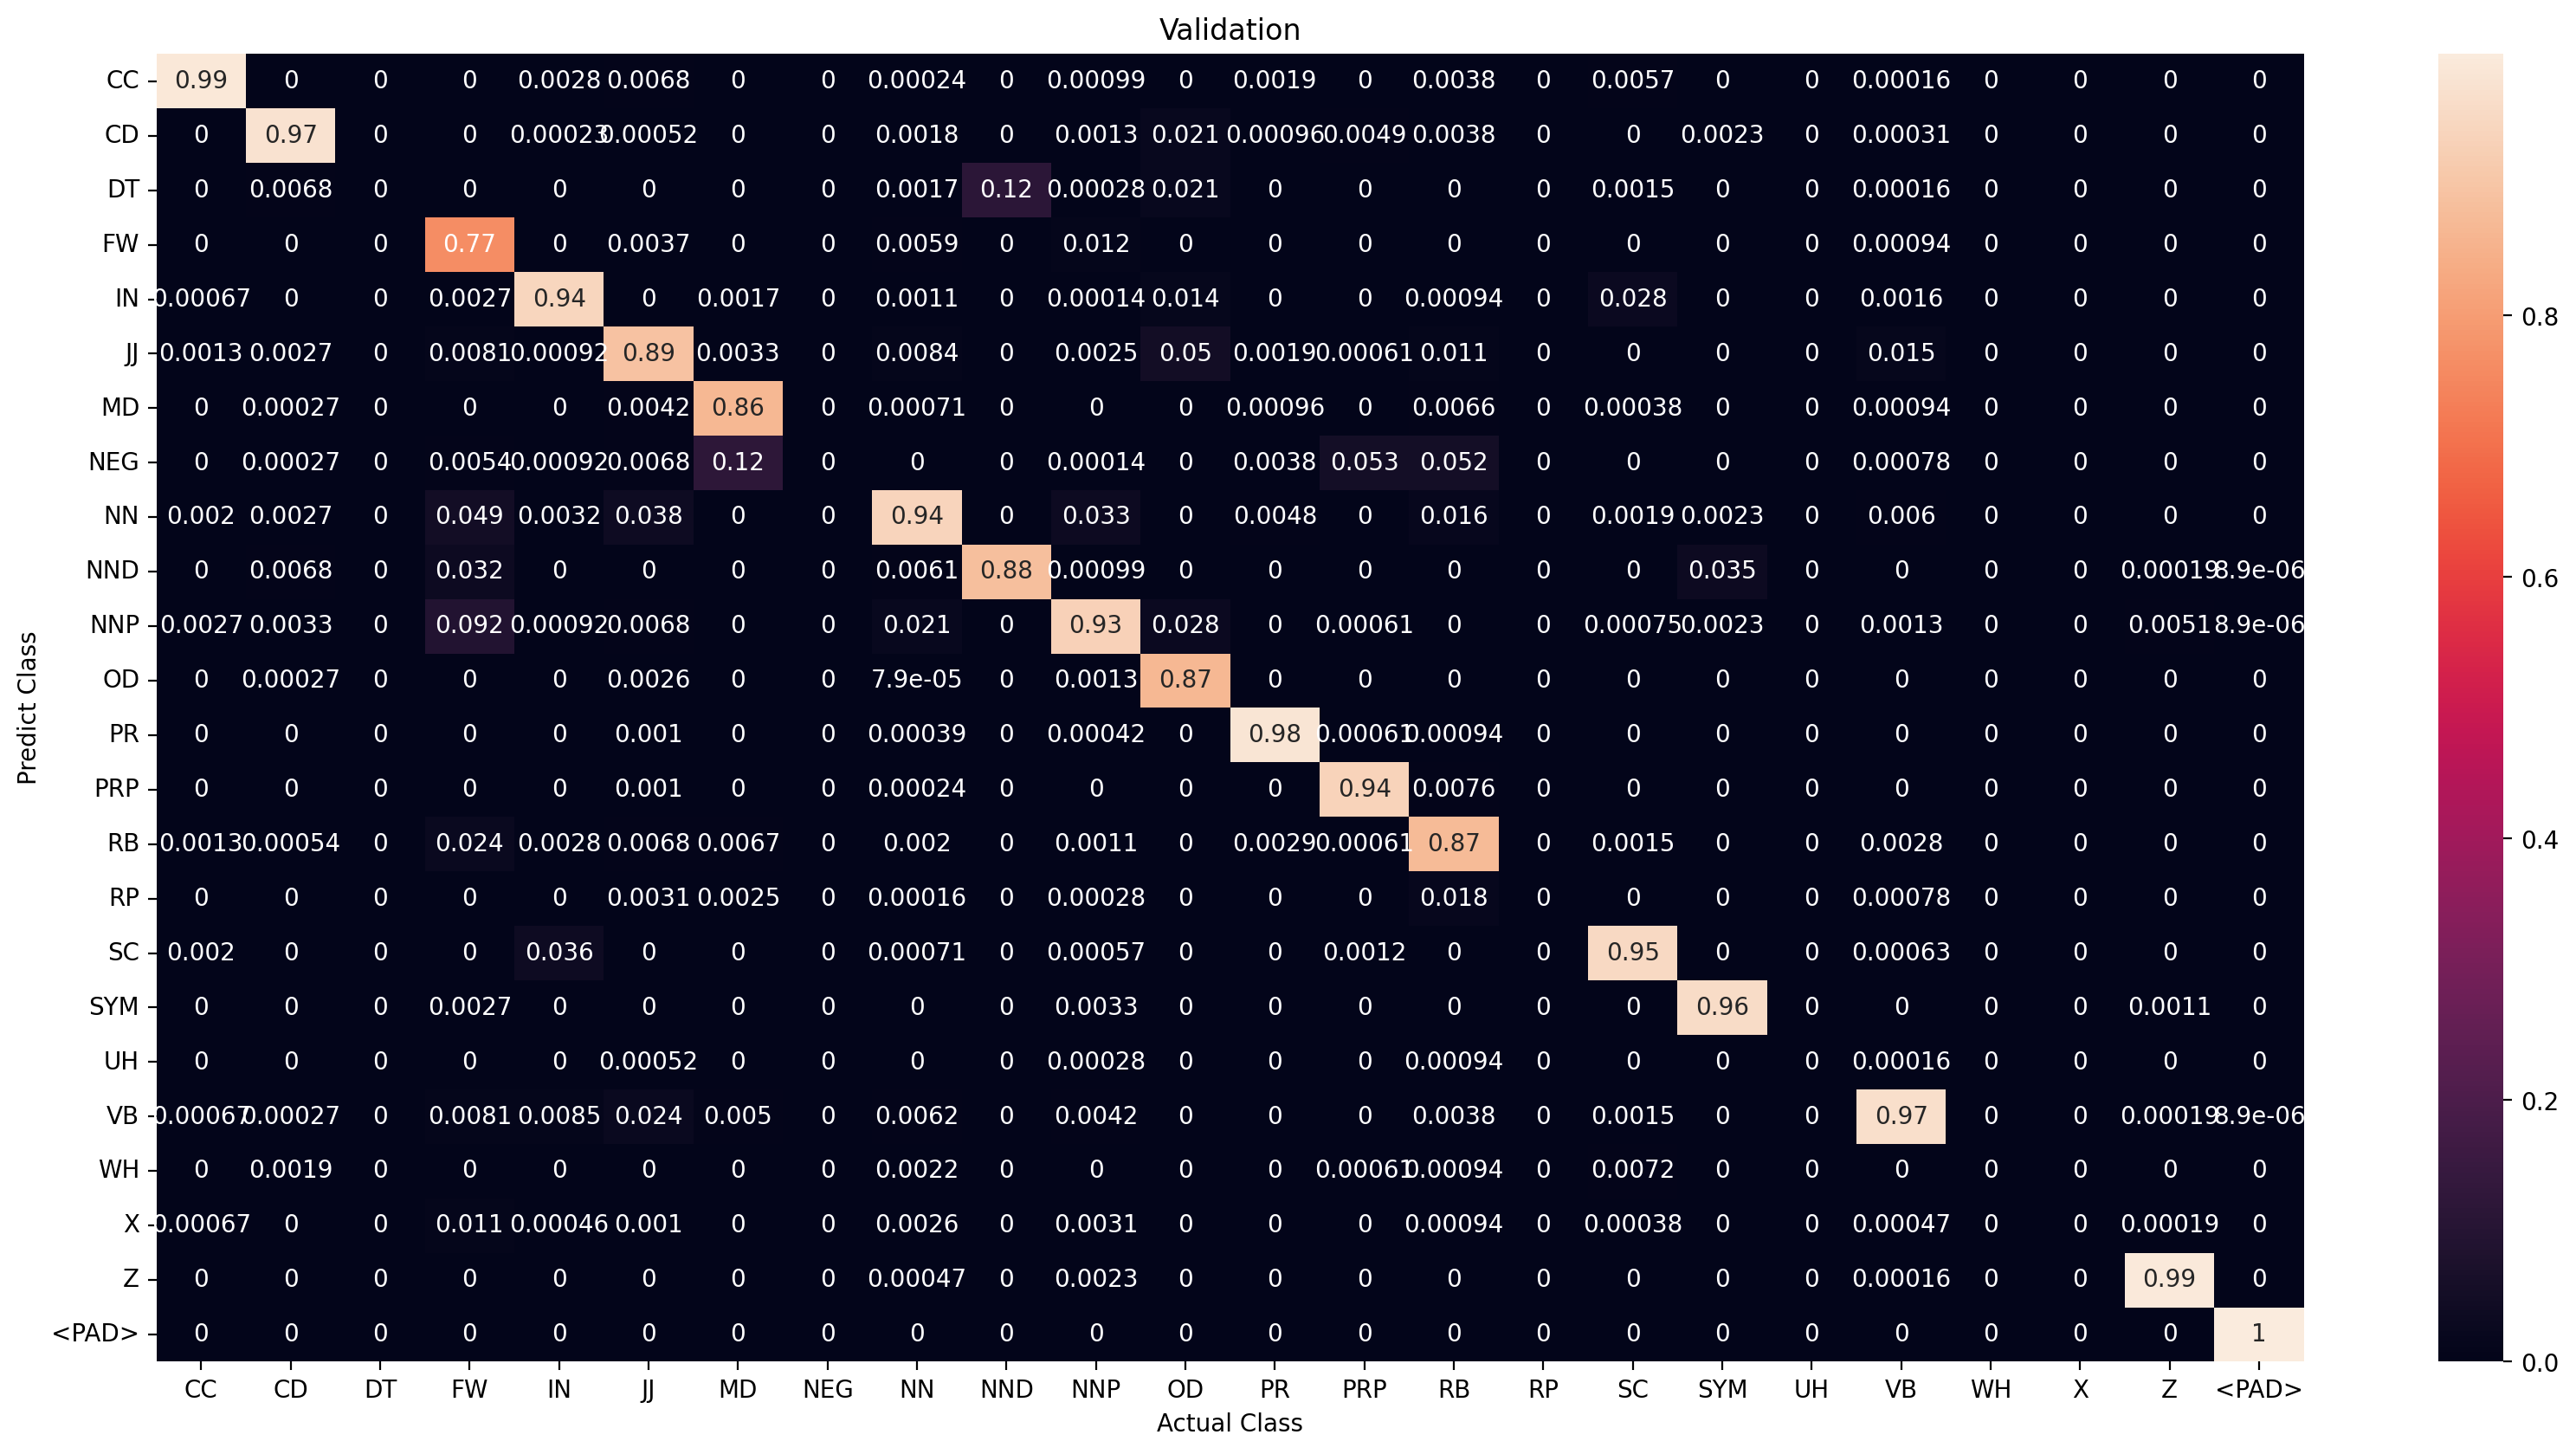

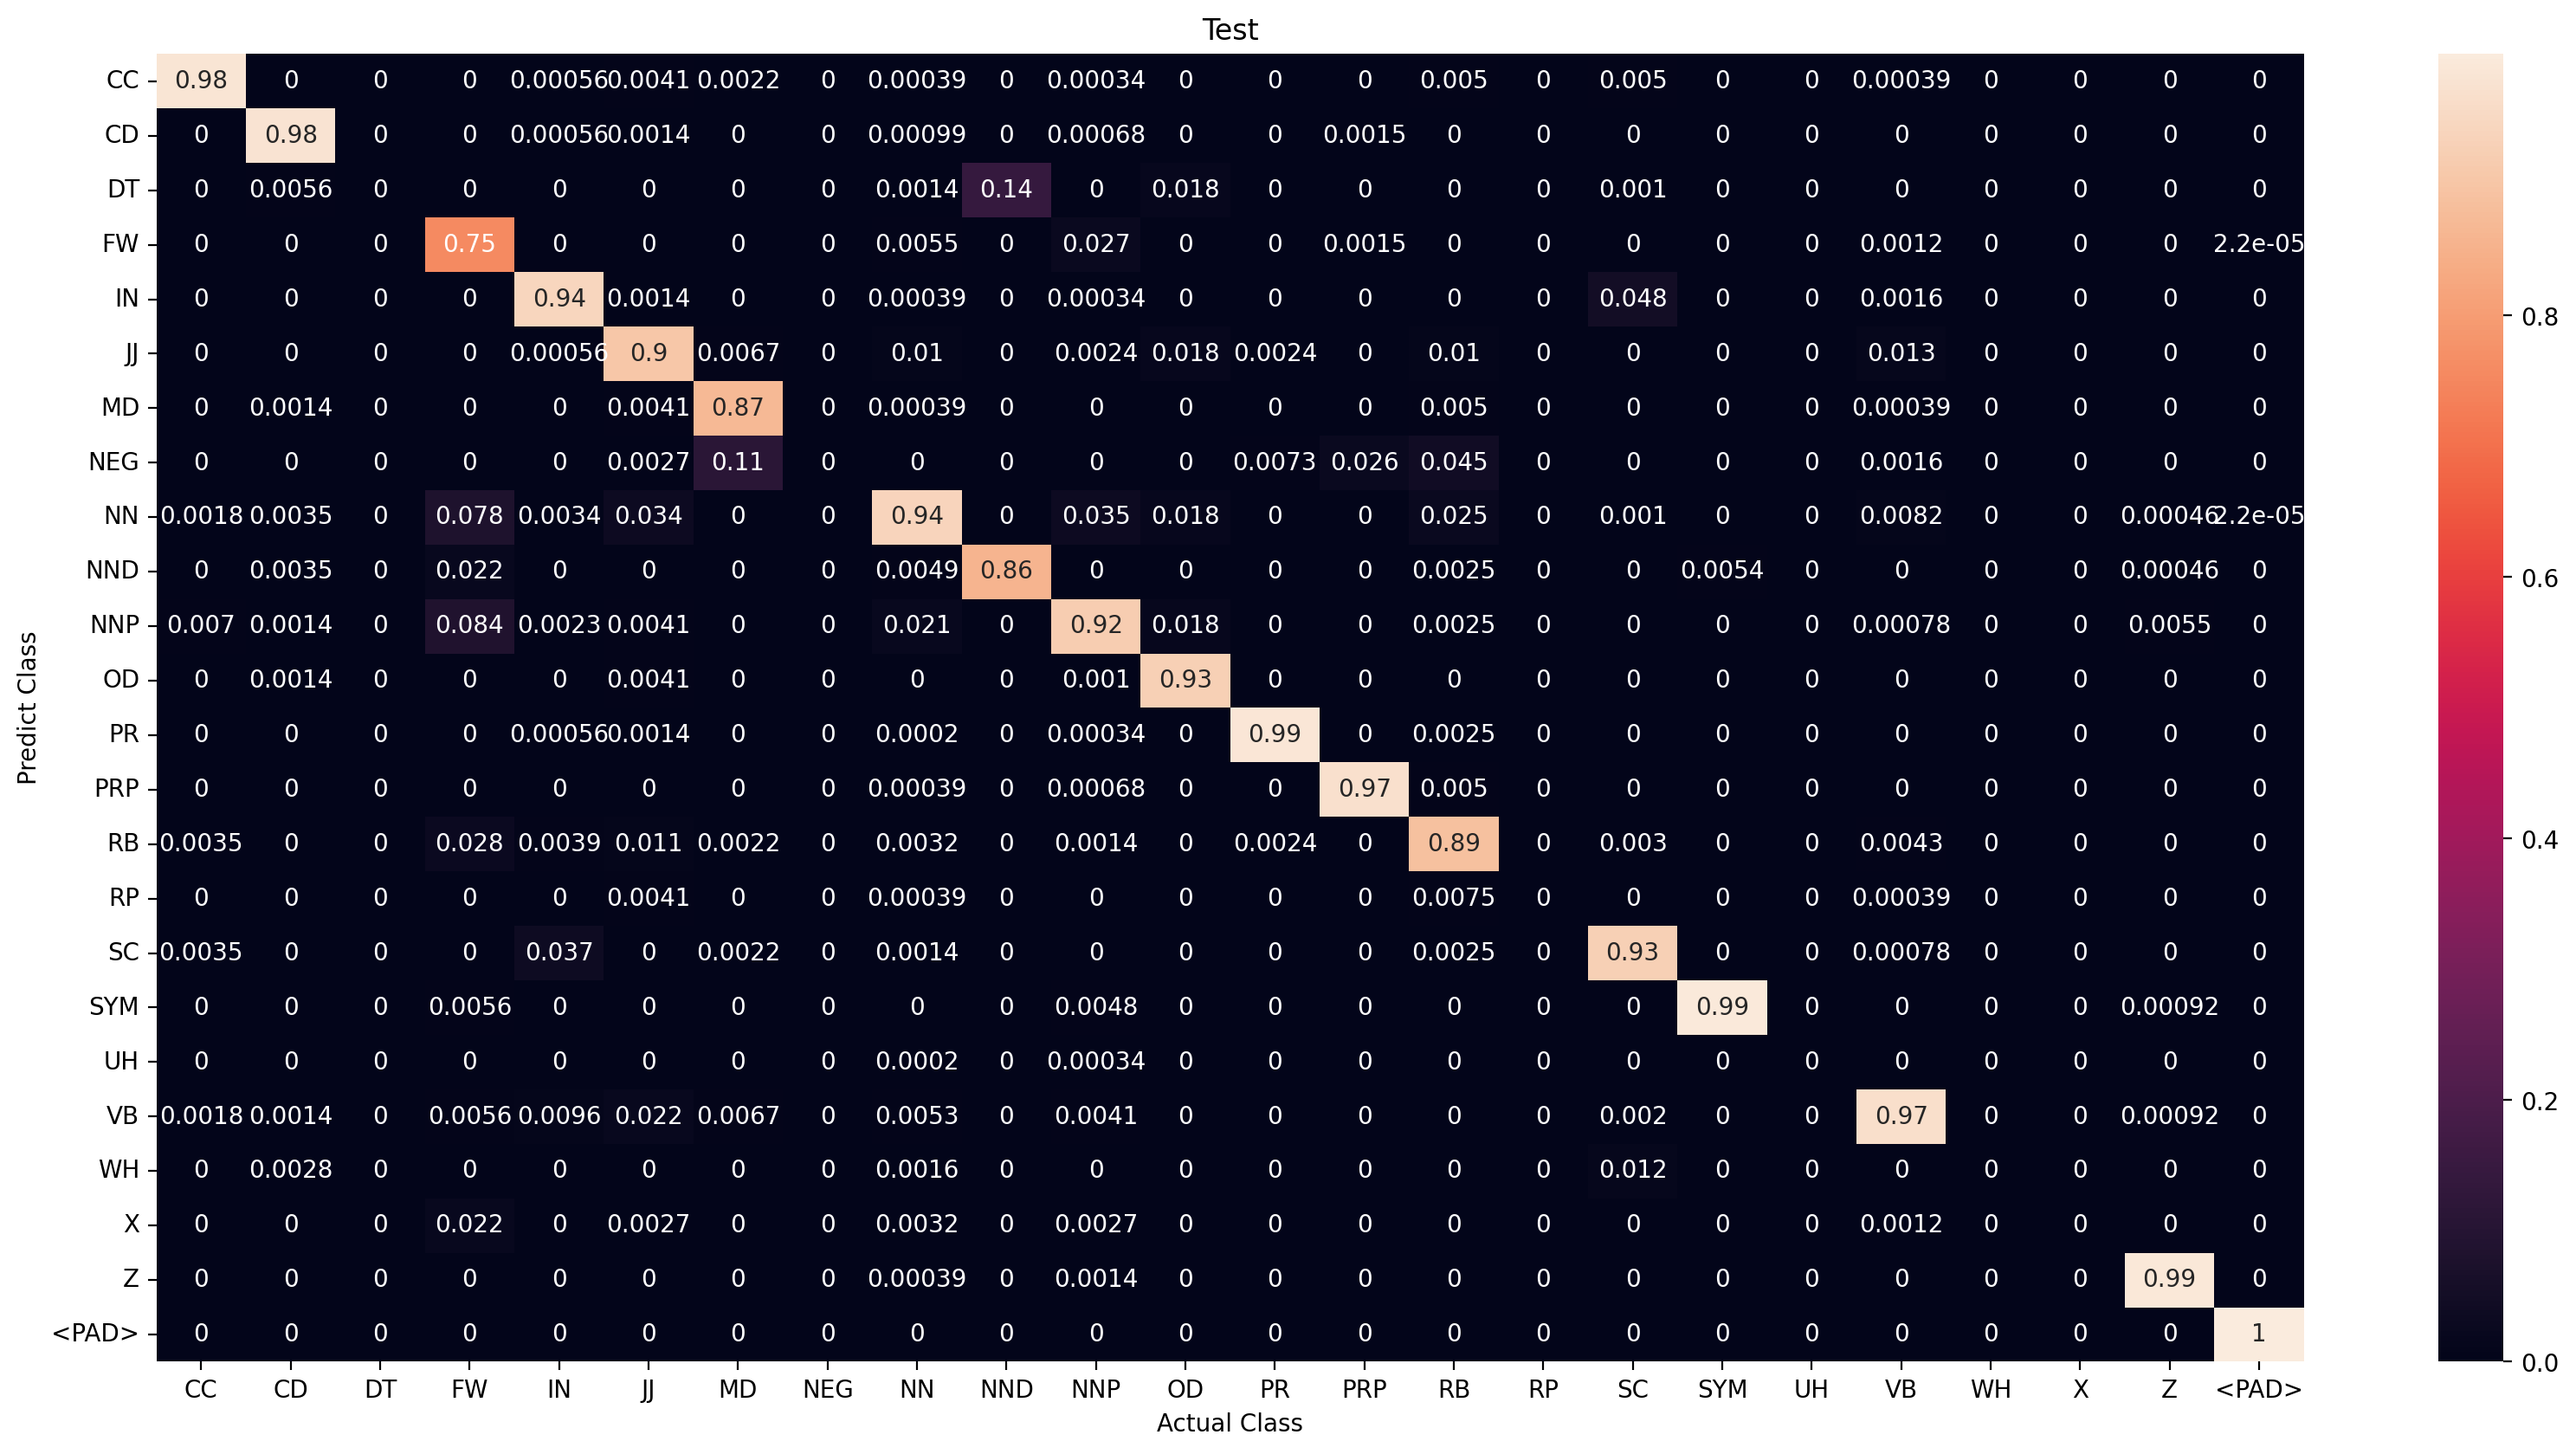

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5198       | CC    : 124      |
| CD    : 12758  | CD    : 12674      | CD    : 84       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1375       | FW    : 291      |
| IN    : 15371  | IN    : 15218      | IN    : 153      |
| JJ    : 6997   | JJ    : 6506       | JJ    : 491      |
| MD    : 3774   | MD    : 3665       | MD    : 109      |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44063      | NN    : 609      |
| NND   : 1021   | NND   : 532        | NND   : 489      |
| NNP   : 24845  | NNP   : 24298      | NNP   : 547      |
| OD    : 541    | OD    : 523        | OD    : 18       |
| PR    : 3896   | PR    : 3860       | PR    : 36       |
| PRP   : 5408   | PRP   : 5363       | PRP   : 45       |
| RB    : 3463   | RB    : 3245       | RB    : 218      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 10973
Wrong prediction            : 848
Percentage correct oov pred : 92.8263260299467

Validation
Number OOV token            : 3350
Correct prediction          : 2933
Wrong prediction            : 417
Percentage correct oov pred : 87.55223880597015

Test
Number OOV token            : 1391
Correct prediction          : 1226
Wrong prediction            : 165
Percentage correct oov pred : 88.13803019410497



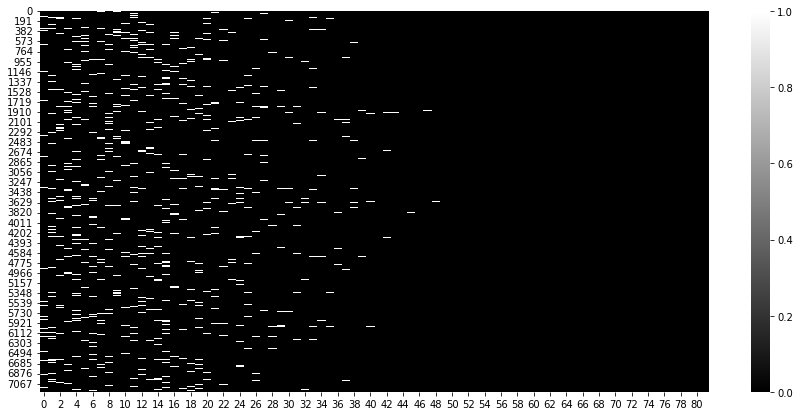

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

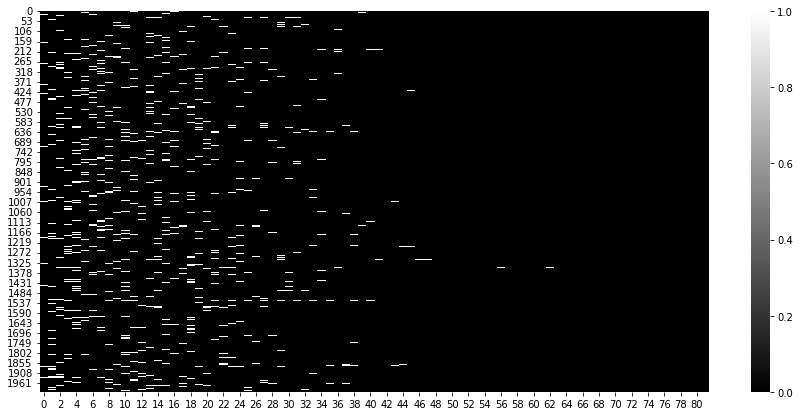

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

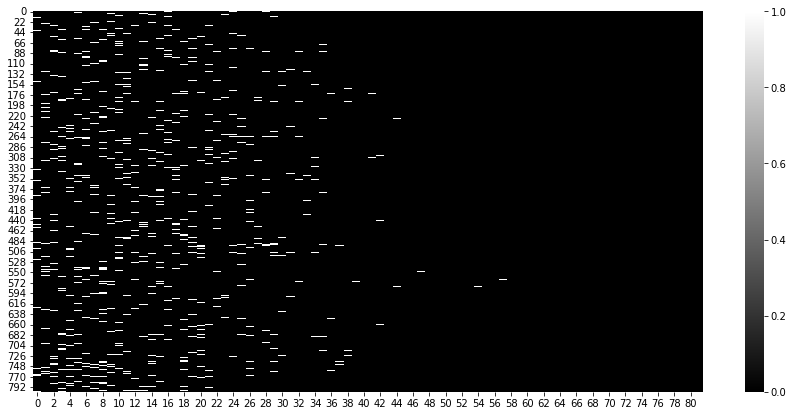

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);